In [2]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datasets import load_dataset
from einops import rearrange
from utils import get_separated_activations, flattened_idx_to_layer_head
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import requests 

/data/wtl/anaconda3/envs/iti/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def get_separated_activations(labels, head_wise_activations, categories): 

    # separate activations by question
    url = "https://huggingface.co/api/datasets/truthful_qa/parquet/multiple_choice/validation/0.parquet"
    dataset = load_dataset('parquet', data_files=url)['train']
    actual_labels = []
    for i in range(len(dataset)):
        actual_labels.append(dataset[i]['mc2_targets']['labels'])
    

    idxs_to_split_at = np.cumsum([len(x) for x in actual_labels])        

    labels = list(labels)
    categories = list(categories)
    separated_labels = []
    separated_categories = []
    for i in range(len(idxs_to_split_at)):
        if i == 0:
            separated_labels.append(labels[:idxs_to_split_at[i]])
            separated_categories.append(categories[:idxs_to_split_at[i]])
        else:
            separated_labels.append(labels[idxs_to_split_at[i-1]:idxs_to_split_at[i]])
            separated_categories.append(categories[idxs_to_split_at[i-1]:idxs_to_split_at[i]])

    separated_head_wise_activations = np.split(head_wise_activations, idxs_to_split_at)

    return separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at

In [4]:

labels = np.load(f'/data/wtl/honest_llm/activations/llama_7B_tqa_mc2_all_100_labels.npy')
activation_categories = pkl.load(open(f'/data/wtl/honest_llm/activations/llama_7B_tqa_mc2_all_100_categories.pkl', 'rb'))
tokens = pkl.load(open(f'/data/wtl/honest_llm/activations/llama_7B_tqa_mc2_all_100_tokens.pkl', 'rb'))
num_heads = 32

head_wise_activations_llama_7B = pkl.load(open(f'/data/wtl/honest_llm/activations/llama_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
head_wise_activations_llama_7B = rearrange(head_wise_activations_llama_7B, 'b l (h d) -> b l h d', h = num_heads)

head_wise_activations_llama2_7B = pkl.load(open(f'/data/wtl/honest_llm/activations/llama2_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
head_wise_activations_llama2_7B = rearrange(head_wise_activations_llama2_7B, 'b l (h d) -> b l h d', h = num_heads)

head_wise_activations_llama2_chat_7B = pkl.load(open(f'/data/wtl/honest_llm/activations/llama2_chat_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
head_wise_activations_llama2_chat_7B= rearrange(head_wise_activations_llama2_chat_7B, 'b l (h d) -> b l h d', h = num_heads)


separated_head_wise_activations_llama_7B, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(labels, head_wise_activations_llama_7B, activation_categories)
separated_head_wise_activations_llama2_7B, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(labels, head_wise_activations_llama2_7B, activation_categories)
separated_head_wise_activations_llama2_chat_7B, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(labels, head_wise_activations_llama2_chat_7B, activation_categories)

Found cached dataset parquet (/data/wtl/hf_cache/parquet/default-45ee6c5a774c2d3f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 447.68it/s]
Found cached dataset parquet (/data/wtl/hf_cache/parquet/default-45ee6c5a774c2d3f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 542.81it/s]
Found cached dataset parquet (/data/wtl/hf_cache/parquet/default-45ee6c5a774c2d3f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 673.35it/s]


In [5]:
head_wise_activation_directions_llama_7B = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations_llama_7B, separated_labels)])
head_wise_activation_directions_llama2_7B = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations_llama2_7B, separated_labels)])
head_wise_activation_directions_llama2_chat_7B = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations_llama2_chat_7B, separated_labels)])

question_categories = [_[0] for _ in separated_categories]
categories = list(set(question_categories))

In [11]:
layer = 11
head = 6
subclass_names = ['Confusion: People',
            'Confusion: Other',
            'Logical Falsehood',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            ]

subclass2class = {'Confusion: People':'Confusion',
                'Confusion: Other':'Confusion', 
                'Logical Falsehood':'Logical Falsehood', 
                'Indexical Error: Time':'Indexical Error',
                'Indexical Error: Location':'Indexical Error',
                'Indexical Error: Other':'Indexical Error'
                }

selected_idx = [i for i, sel in enumerate(question_categories) if sel in subclass_names]
selected_subclass = [question_categories[i] for i in selected_idx]
selected_class = [subclass2class[_] for _ in selected_subclass]
selected_data_llama_7B = head_wise_activation_directions_llama_7B[selected_idx, layer, head, :]
selected_data_llama2_7B = head_wise_activation_directions_llama2_7B[selected_idx, layer, head, :]
selected_data_llama2_chat_7B = head_wise_activation_directions_llama2_chat_7B[selected_idx, layer, head, :]

# selected_data_llama_7B = head_wise_activation_directions_llama_7B[selected_idx].reshape(len(selected_idx), -1, 128).mean(axis=1)
# selected_data_llama2_7B = head_wise_activation_directions_llama2_7B[selected_idx].reshape(len(selected_idx), -1, 128).mean(axis=1)
# selected_data_llama2_chat_7B = head_wise_activation_directions_llama2_chat_7B[selected_idx].reshape(len(selected_idx), -1, 128).mean(axis=1)

# Assign colors and markers
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markers = ['o', 'o', 's', '^', '^', '^']



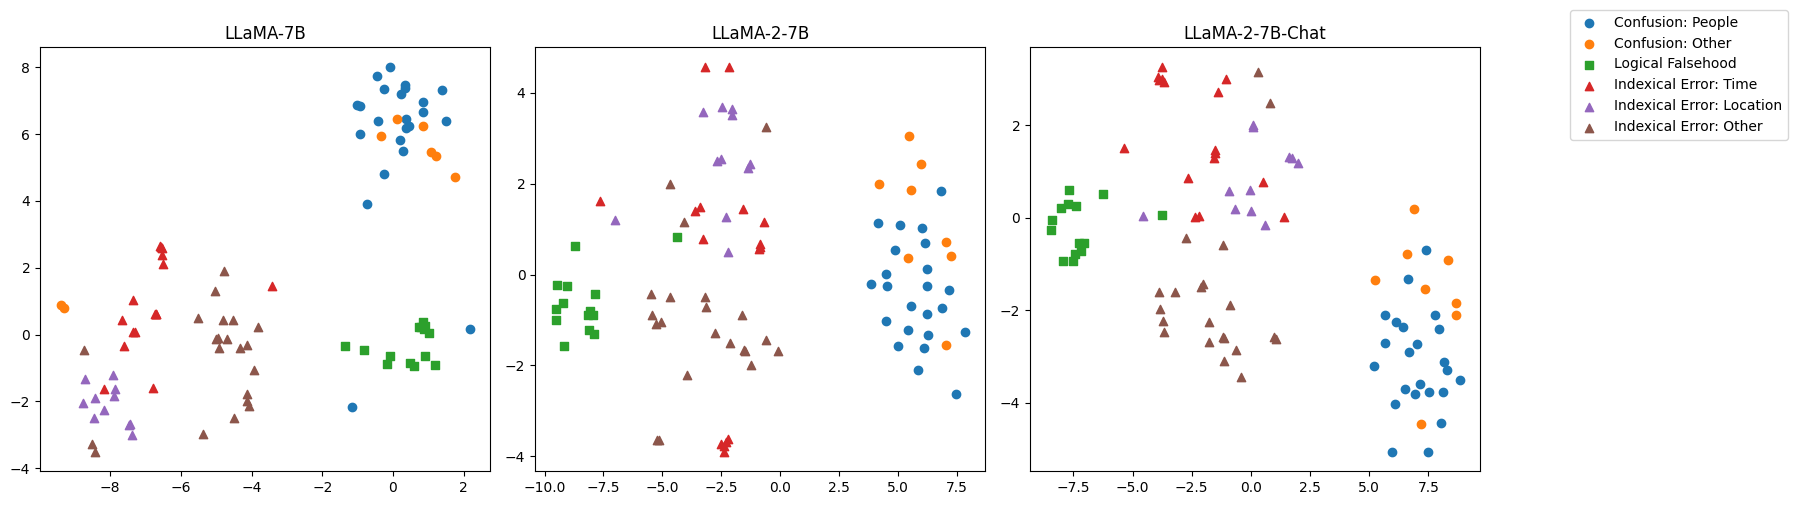

In [12]:
# t-SNE绘图函数
def plot_tsne(data, ax, title):
    # 标准化数据
    data_normalized = data / np.linalg.norm(data, axis=-1, keepdims=True)
    # t-SNE 降维
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(data_normalized)
    
    # 绘制每个子类别的散点
    for i, subclass in enumerate(subclass_names):
        idx = [j for j, x in enumerate(selected_subclass) if x == subclass]
        ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], 
                   color=colors[i], marker=markers[i], label=subclass)
    
    ax.set_title(title)

# 创建一个画布和3个子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

# 绘制LLaMA-7B的散点图
plot_tsne(selected_data_llama_7B, axes[0], 'LLaMA-7B')
# 绘制LLaMA-2-7B的散点图
plot_tsne(selected_data_llama2_7B, axes[1], 'LLaMA-2-7B')
# 绘制LLaMA-2-7B-Chat的散点图
plot_tsne(selected_data_llama2_chat_7B, axes[2], 'LLaMA-2-7B-Chat')

# 在图形旁边创建一个统一的图例
# 注意，我们只在第一个子图上调用label参数，以避免重复图例条目
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 调整布局，留出空间放置图例
plt.tight_layout()

# 显示图形
plt.show()

In [52]:
# t-SNE绘图函数
def plot_tsne(data, ax, title):
    # 标准化数据
    data_normalized = data / np.linalg.norm(data, axis=-1, keepdims=True)
    # t-SNE 降维
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(data_normalized)
    
    # 绘制每个子类别的散点
    for i, subclass in enumerate(subclass_names):
        idx = [j for j, x in enumerate(selected_subclass) if x == subclass]
        ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], 
                   color=colors[i], marker=markers[i], label=subclass)
    
    ax.set_title(title)

# 创建一个画布和3个子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=1500)

# 绘制LLaMA-2-7B的散点图
plot_tsne(selected_data_llama2_7B, axes[0], 'LLaMA-2-7B')
# 绘制LLaMA-2-7B-Chat的散点图
plot_tsne(selected_data_llama2_chat_7B, axes[1], 'LLaMA-2-7B-Chat')

# 在图形旁边创建一个统一的图例
# 注意，我们只在第一个子图上调用label参数，以避免重复图例条目
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc=2, fontsize=15, borderaxespad=0.)

# 调整布局，留出空间放置图例
plt.tight_layout()

# 显示图形
plt.show()

In [56]:
# t-SNE绘图函数
def plot_tsne(data, ax, title):
    # 标准化数据
    data_normalized = data / np.linalg.norm(data, axis=-1, keepdims=True)
    # t-SNE 降维
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(data_normalized)
    
    # 绘制每个子类别的散点
    for i, subclass in enumerate(subclass_names):
        idx = [j for j, x in enumerate(selected_subclass) if x == subclass]
        ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], 
                   color=colors[i], marker=markers[i], label=subclass, s=50)
    
    ax.tick_params(axis='x', labelsize=14)  # 设置x轴刻度标签的字体大小
    ax.tick_params(axis='y', labelsize=14)  # 设置y轴刻度标签的字体大小
    ax.set_title(title, fontsize = 20)

# 创建一个画布和3个子图
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=1500)

# 绘制LLaMA-2-7B的散点图
plot_tsne(selected_data_llama_7B, axes[0], 'LLaMA-7B')
# 绘制LLaMA-2-7B-Chat的散点图
plot_tsne(selected_data_llama2_chat_7B, axes[1], 'LLaMA-2-7B-Chat')

# 在图形旁边创建一个统一的图例
# 注意，我们只在第一个子图上调用label参数，以避免重复图例条目
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc=2, markerscale=1.5, fontsize=18, borderaxespad=0.)

# 调整布局，留出空间放置图例
plt.tight_layout()

# 显示图形
# plt.show()
plt.savefig('vis_cluster.pdf', bbox_inches='tight')